
# Warmart Sales Forecasting and Exploratory Data Analysis



**Table of Contents**  

1. Introduction
    - 1.1 Background  
    - 1.2 Objective  
    - 1.3 Dataset
2. Library Imports and Data Loading  
3. Preprocessing  
4. Exploratory Data Analysis (EDA)  
    - 4.1 Relationship Between Store Size and Store Type  
    - 4.2 Weekly Sales by Year  
    - 4.3 Store and Department Sales Overview  
    - 4.4 Markdowns Relationship with Sales  
    - 4.5 Encoding categorical data  
    - 4.6 Relationship Between External Factors and Weekly Sales  
    - 4.7 Feature correlation  
5. Feature Engineering  
6. Feature Importance  
7. Model Evaluation with WMAE  
8. Baseline predictions  
9. Actual vs Forecast 


## 1.Introduction

**1.1 Background**

Walmart has provided historical sales data for 45 stores located in different regions. Each store contains a number of departments.The dataset includes weekly sales figures along with economic and promotional indicators. Key promotional markdown events are timed around major holidays such as Christmas, Thanksgiving, Labor Day, and the Super Bowl. Weeks containing these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this project is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.


**1.2 Objective**

The primary objective is to build a predictive model to forecast weekly department-level sales for each Walmart store. Additionally, the project explores how external factors such as temperature, CPI, markdowns, and major holidays impact sales, providing insights to improve forecast accuracy and understand demand drivers. 

**1.3 Dataset**  

1.`stores.csv`

This file contains anonymized information about the 45 stores, indicating the `type` and `size` of `store`.

2. `train.csv`

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:  
`Store` - the store number  
`Dept` - the department number  
`Date` - the week  
`Weekly_Sales` -  sales for the given department in the given store  
`IsHoliday` - whether the week is a special holiday week

3. `test.csv`

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

4. `features.csv`

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

`Store` - the store number  
`Date` - the week  
`Temperature` - average temperature in the region  
`Fuel_Price` - cost of fuel in the region  
`MarkDown1-5` - anonymized data related to promotional markdowns that Walmart is running.  MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.  
`CPI` - the consumer price index  
`Unemployment` - the unemployment rate  
`IsHoliday` - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13  
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13  
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13  
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

## 2.Library Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

#Feature Selection
import eli5
from eli5.sklearn import PermutationImportance

# Sklearn
from sklearn import model_selection, metrics

#Models
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn import linear_model, ensemble
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
pd.set_option('display.max_columns',100)

In [3]:
features = pd.read_csv('/features.csv')

In [4]:
stores = pd.read_csv('/stores.csv')

In [5]:
train = pd.read_csv('/train.csv')

In [6]:
test = pd.read_csv('/test.csv')

In [7]:
stores.shape, train.shape, features.shape, test.shape

((45, 3), (421570, 5), (8190, 12), (115064, 4))

In [8]:
store_features = stores.merge(features,how = 'inner', on = 'Store')

In [9]:
print("test columns:", test.columns.tolist())
print("store_features columns:", store_features.columns.tolist())

test columns: ['Store', 'Dept', 'Date', 'IsHoliday']
store_features columns: ['Store', 'Type', 'Size', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']


In [10]:
df_train = (
    train.merge(store_features,how='inner', on=['Store','Date'])
    .sort_values(by=['Store','Dept','Date'])
    .reset_index(drop=True)
)

In [11]:
df_test = (
    test.merge(store_features,how='inner', on=['Store','Date'])
    .sort_values(by=['Store','Dept','Date'])
    .reset_index(drop=True)
)

In [12]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [13]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


## 3.Preprocessing

In [14]:
(df_train['IsHoliday_x'] == df_train['IsHoliday_y']).all()

True

In [15]:
(df_test['IsHoliday_x'] == df_test['IsHoliday_y']).all()

True

In [16]:
df_train.drop(columns=['IsHoliday_y'], inplace=True)
df_train.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

In [17]:
df_test.drop(columns=['IsHoliday_y'], inplace=True)
df_test.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

In [18]:
df_train.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

In [19]:
df_test.isna().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64

In [20]:
df_train=df_train.fillna(0)

In [21]:
df_test=df_test.fillna(0)

In [22]:
#Converting date to datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train['Year'] = df_train['Date'].dt.year
df_train['Month'] = df_train['Date'].dt.month
df_train['Week'] = df_train['Date'].dt.isocalendar().week
df_train['Day'] = df_train['Date'].dt.day

In [23]:
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['Year'] = df_test['Date'].dt.year
df_test['Month'] = df_test['Date'].dt.month
df_test['Week'] = df_test['Date'].dt.isocalendar().week
df_test['Day'] = df_test['Date'].dt.day

In [24]:
df_test['Date'].agg(['min', 'max'])

min   2012-11-02
max   2013-07-26
Name: Date, dtype: datetime64[ns]

In [25]:
df_train['Date'].agg(['min', 'max'])

min   2010-02-05
max   2012-10-26
Name: Date, dtype: datetime64[ns]

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     421570 non-null  float64       
 10  MarkDown2     421570 non-null  float64       
 11  MarkDown3     421570 non-null  float64       
 12  MarkDown4     421570 non-null  float64       
 13  MarkDown5     421570 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         115064 non-null  int64         
 1   Dept          115064 non-null  int64         
 2   Date          115064 non-null  datetime64[ns]
 3   IsHoliday     115064 non-null  bool          
 4   Type          115064 non-null  object        
 5   Size          115064 non-null  int64         
 6   Temperature   115064 non-null  float64       
 7   Fuel_Price    115064 non-null  float64       
 8   MarkDown1     115064 non-null  float64       
 9   MarkDown2     115064 non-null  float64       
 10  MarkDown3     115064 non-null  float64       
 11  MarkDown4     115064 non-null  float64       
 12  MarkDown5     115064 non-null  float64       
 13  CPI           115064 non-null  float64       
 14  Unemployment  115064 non-null  float64       
 15  Year          115

In [28]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,Day
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2010,2,6,12
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,2010,2,7,19
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,2010,2,8,26
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,2010,3,9,5


## 4.Exploratory Data Analysis (EDA)

In [29]:
numeric_df = df_train.select_dtypes(include='number')
numeric_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.0,11.0,22.0,33.0,45.0
Dept,421570.0,44.260317,30.492054,1.0,18.0,37.0,74.0,99.0
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.94,2079.65,7612.03,20205.8525,693099.36
Size,421570.0,136727.915739,60980.583328,34875.0,93638.0,140167.0,202505.0,219622.0
Temperature,421570.0,60.090059,18.447931,-2.06,46.68,62.09,74.28,100.14
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933,3.452,3.738,4.468
MarkDown1,421570.0,2590.074819,6052.385934,0.0,0.0,0.0,2809.05,88646.76
MarkDown2,421570.0,879.974298,5084.538801,-265.76,0.0,0.0,2.2,104519.54
MarkDown3,421570.0,468.087665,5528.873453,-29.1,0.0,0.0,4.54,141630.61
MarkDown4,421570.0,1083.132268,3894.529945,0.0,0.0,0.0,425.29,67474.85


The `Weekly_Sales` column has a mean of 15,981.26, while the median is significantly lower at 7612.03, indicating a right-skewed distribution. Additionally, there are outliers, with some weeks reaching 693,099.

## 4 Exploratory Data Analysis (EDA)
### 4.1 Relationship Between Store Size and Store Type

In [30]:
stores.groupby('Type')['Size'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


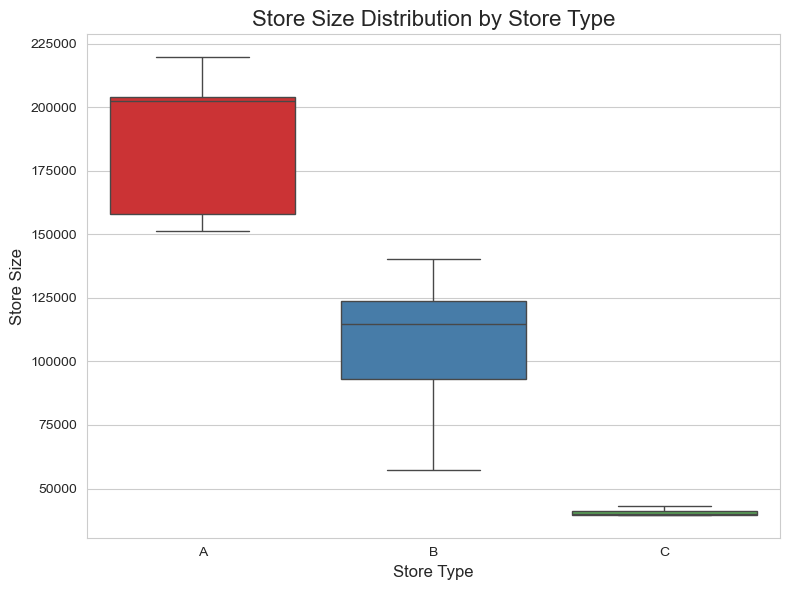

In [31]:
plt.figure(figsize=(8, 6)) 

fig = sns.boxplot(
    x='Type', 
    y='Size', 
    data=df_train, 
    showfliers=False,   # Remove outliers
    hue='Type',         
    legend=False,       
    palette='Set1'      
)
plt.title('Store Size Distribution by Store Type', fontsize=16)
plt.xlabel('Store Type', fontsize=12)
plt.ylabel('Store Size', fontsize=12)
plt.tight_layout()
plt.show()

Type A stores are significantly larger on average, with a wide range of sizes, representing the largest store format. Type B stores are mid-sized and exhibit more variability than Type C, though less than Type A. Type C stores are the smallest and most consistent in size—likely representing Walmart Express stores, which offer a smaller, more convenient shopping experience in urban and suburban areas.

### 4.2 Weekly Sales by Year

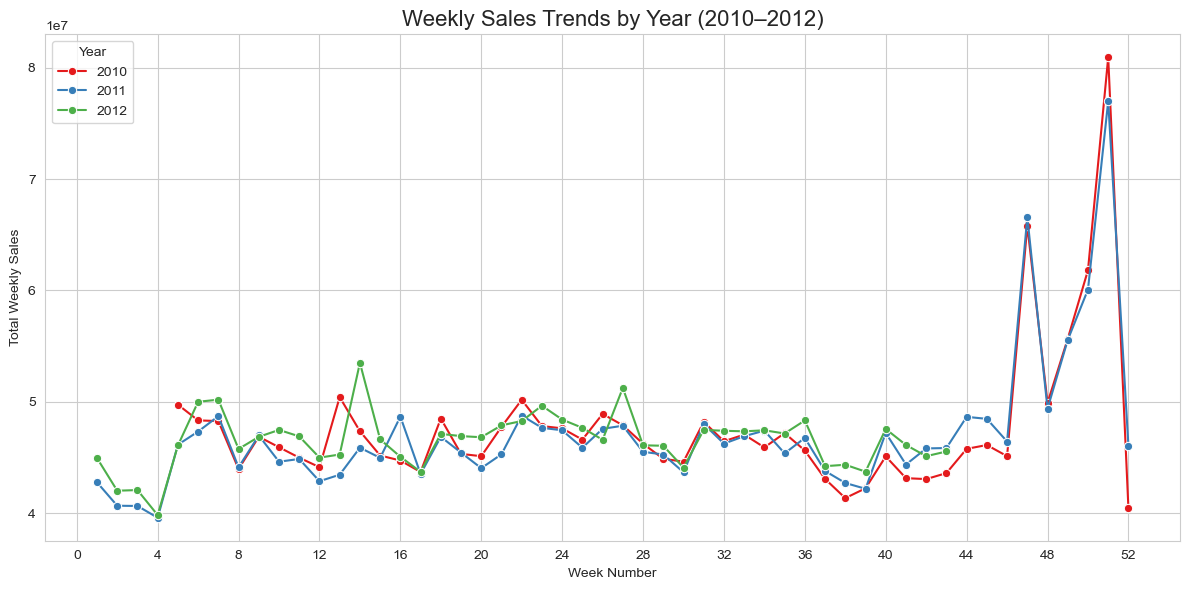

In [32]:
weekly_sales = df_train.groupby(['Year', 'Week'])['Weekly_Sales'].sum().reset_index()
# Set seaborn style

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=weekly_sales,
    x='Week',
    y='Weekly_Sales',
    hue='Year',
    marker='o',
    palette= 'Set1'             
)

plt.title('Weekly Sales Trends by Year (2010–2012)',fontsize=16)
plt.xlabel('Week Number')
plt.ylabel('Total Weekly Sales')
plt.xticks(ticks=range(0, 53, 4))
plt.tight_layout()
plt.show()

From the graph, we observe that weekly sales across the three years remain relatively stable between `$40` million and $50 million for most of the year, indicating a consistent baseline in consumer demand. A sharp spike appears between weeks 47 and 51, which aligns with the holiday shopping season—particularly Thanksgiving, Black Friday, and Christmas.At the beginning of each year, there is a noticeable drop in sales, likely reflecting a post-holiday slowdown in consumer activity.

### 4.3 Store and Department Sales Overview

We combined scatter plots and average weekly sales bar charts to analyze sales performance at both the store and department levels. The scatter plots were particularly helpful in revealing weekly sales variability and identifying occasional performance spikes, which may be linked to promotions or seasonal events. In contrast, the bar charts provided a clearer view of which stores and departments consistently generated strong sales over time.

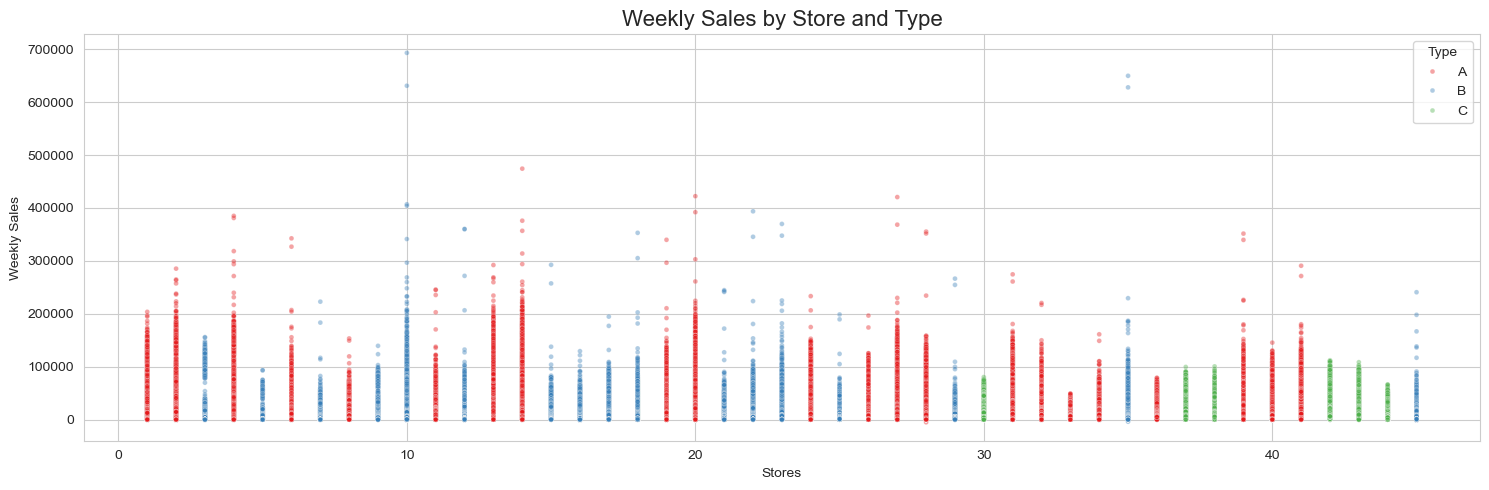

In [33]:
plt.figure(figsize=(15, 5))
sns.scatterplot(
    x='Store',
    y='Weekly_Sales',
    data=df_train,
    hue='Type',             
    alpha=0.4,
    s=12,
    palette='Set1'         
)

plt.title('Weekly Sales by Store and Type', fontsize=16)
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.tight_layout()
plt.show()

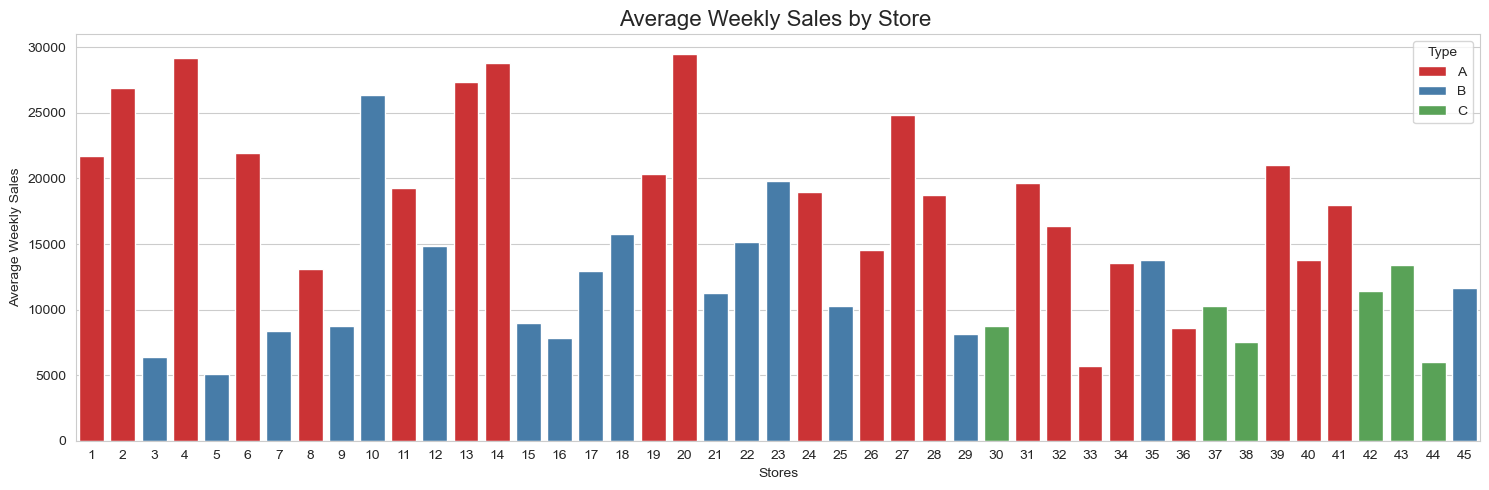

In [34]:
plt.figure(figsize=(15,5))
fig = sns.barplot(x='Store', 
                  y='Weekly_Sales', 
                  data=df_train,
                  estimator='mean',
                  errorbar=None,
                  palette='Set1',
                  hue='Type'
                 )
plt.title('Average Weekly Sales by Store ',fontsize = 16)
plt.xlabel('Stores')
plt.ylabel('Average Weekly Sales')
plt.tight_layout()
plt.show()


In the scatter plot, store 14 and store 10 showed several instances of strong weekly sales performance, indicating they had some high-performing weeks. However, in the average weekly sales chart,it's store 20 that stands out as the top performer overall. This contrast suggests that the high sales observed in store 14 and 10 were likely outliers rather than consistent trends.

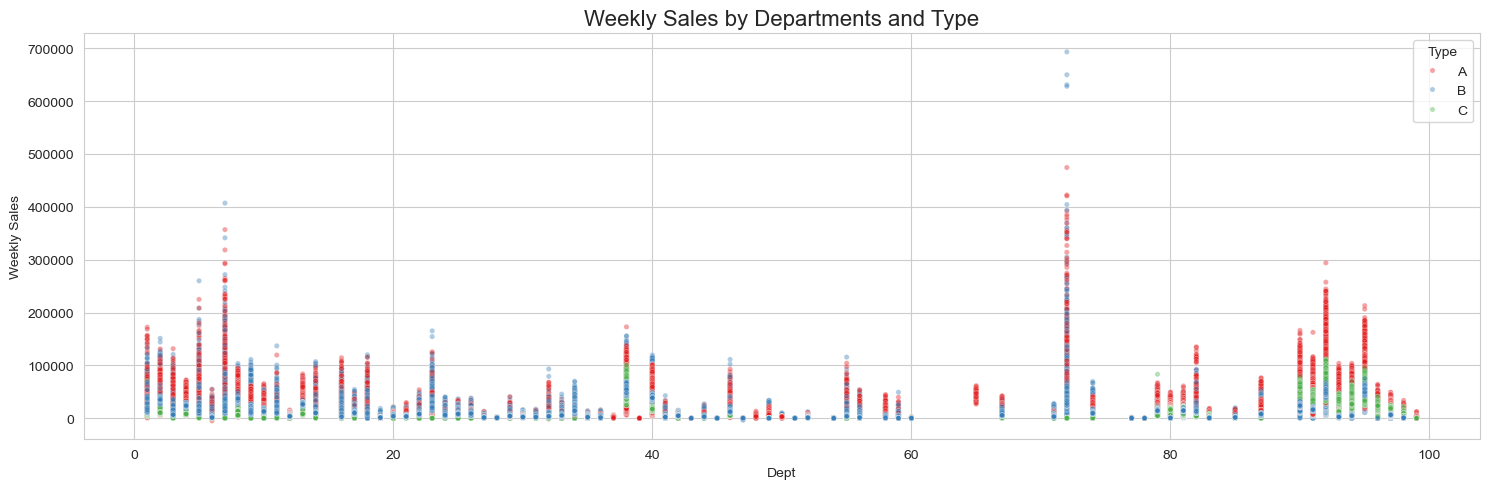

In [35]:
plt.figure(figsize=(15, 5))
sns.scatterplot(
    x='Dept',
    y='Weekly_Sales',
    data=df_train,
    hue='Type',             
    alpha=0.4,
    s=14,
    palette='Set1'       
)

plt.title('Weekly Sales by Departments and Type', fontsize=16)
plt.xlabel('Dept')
plt.ylabel('Weekly Sales')
plt.tight_layout()
plt.show()

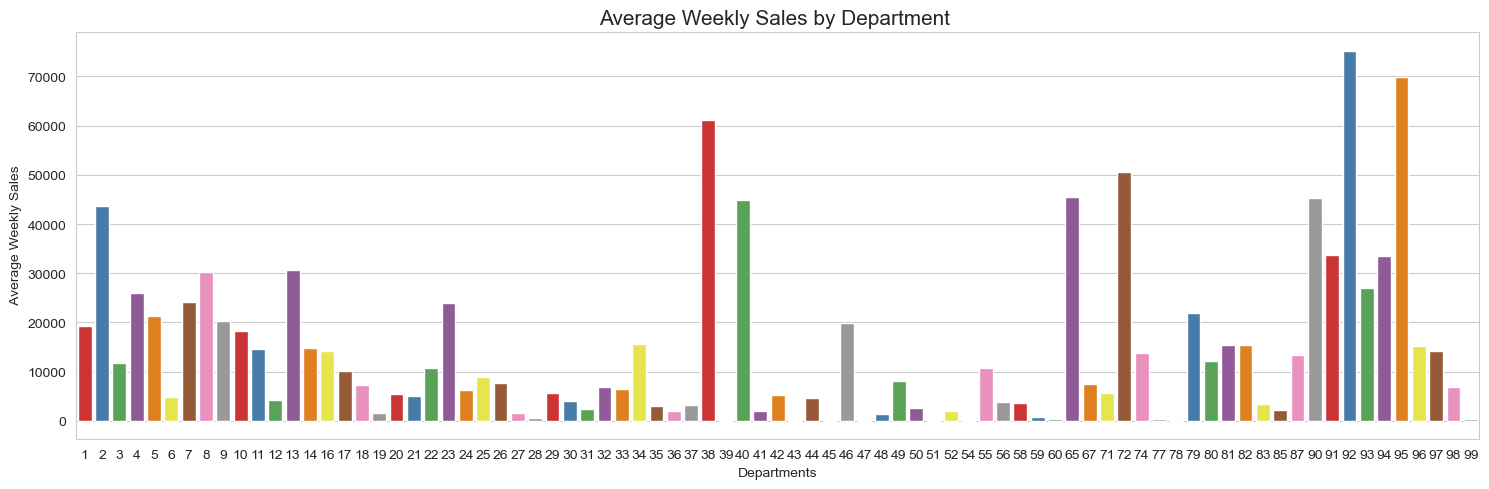

In [36]:
plt.figure(figsize=(15,5))
fig = sns.barplot(
    x='Dept',
    y='Weekly_Sales',
    data=df_train,
    estimator='mean',
    errorbar=None,
    palette='Set1',
    hue = 'Dept',
    legend=False
)
plt.title('Average Weekly Sales by Department ',fontsize = 15)
plt.xlabel('Departments')
plt.ylabel(' Average Weekly Sales')
plt.tight_layout()
plt.show()

The scatter plot indicates that Dept 72 experienced exceptionally high weekly sales, occasionally over $600k. This surge is likely attributed to promotions or seasonal fluctuations. But in the average sales chart, Depts 92, 95, and 38 rank among the top performers. These departments demonstrate a more reliable revenue generation pattern over time.

## 4.4 Markdowns Relationship with Sales

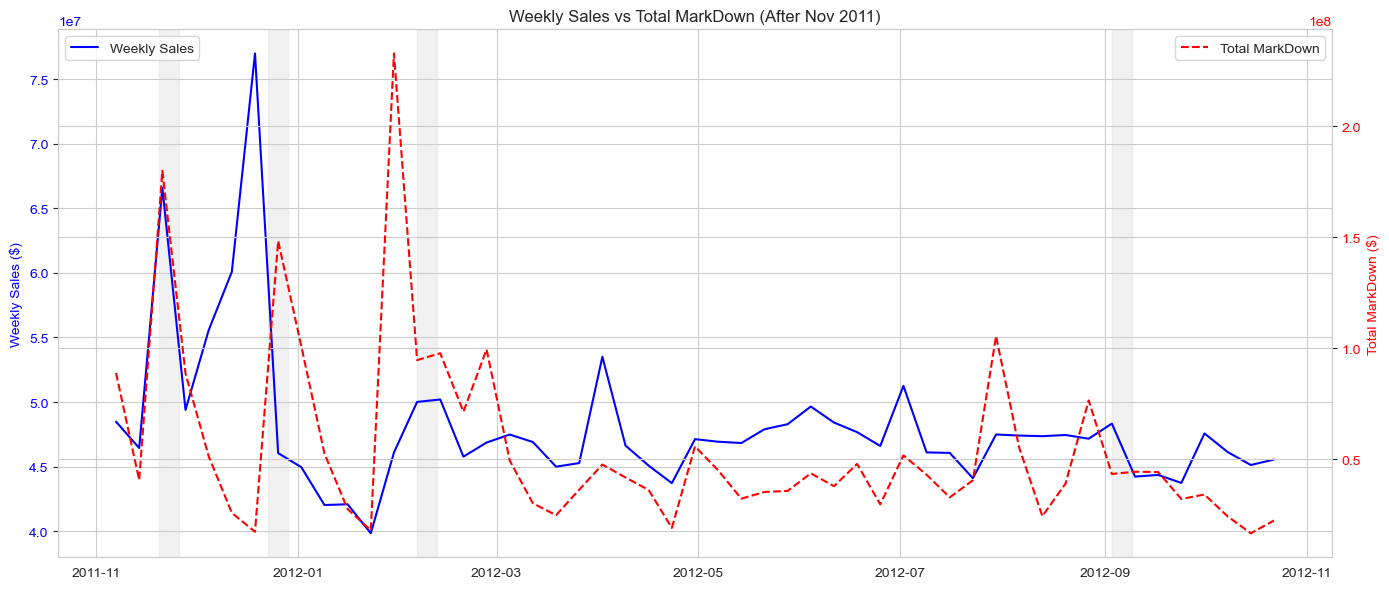

In [37]:
df_train['Date'] = pd.to_datetime(df_train['Date'])

# Filter markdown 
df_markdown = df_train[
    (df_train['Date'] >= '2011-10-31') &
    (df_train[[f'MarkDown{i}' for i in range(1, 6)]].sum(axis=1) > 0)
].copy()

# Create Total_MarkDown and Week columns
df_markdown['Total_MarkDown'] = df_markdown[[f'MarkDown{i}' for i in range(1, 6)]].sum(axis=1)
df_markdown['Week'] = df_markdown['Date'].dt.to_period('W').dt.start_time


weekly_sales = df_markdown.groupby('Week')['Weekly_Sales'].sum()
weekly_markdown = df_markdown.groupby('Week')['Total_MarkDown'].sum()

fig, ax1 = plt.subplots(figsize=(14,6))

# Primary y-axis: Weekly Sales
ax1.plot(weekly_sales.index, weekly_sales, label='Weekly Sales', color='blue')
ax1.set_ylabel('Weekly Sales ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(['Weekly Sales'], loc='upper left')

# Secondary y-axis: Total MarkDown
ax2 = ax1.twinx()
ax2.plot(weekly_markdown.index, weekly_markdown, label='Total MarkDown', color='red', linestyle='--')
ax2.set_ylabel('Total MarkDown ($)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(['Total MarkDown'], loc='upper right')

holiday_ranges = [
    ('2011-11-20', '2011-11-26'),  # Thanksgiving 2011 week
    ('2011-12-23', '2011-12-29'),  # Christmas 2011 week
    ('2012-09-03', '2012-09-09'),  # Labor Day 2012 week
    ('2012-02-06', '2012-02-12')   # Super Bowl 2012 week
]

for start, end in holiday_ranges:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='lightgray', alpha=0.3)

plt.title('Weekly Sales vs Total MarkDown (After Nov 2011)')
fig.tight_layout()
plt.show();

Above chart shows relationship between markdown activity and weekly sales. Markdowns appear to be highly effective during peak shopping periods, particularly around Thanksgiving and Christmas, where both markdowns and sales show sharp increases. but outside those windows,markdowns have a less consistent impact on weekly sales.

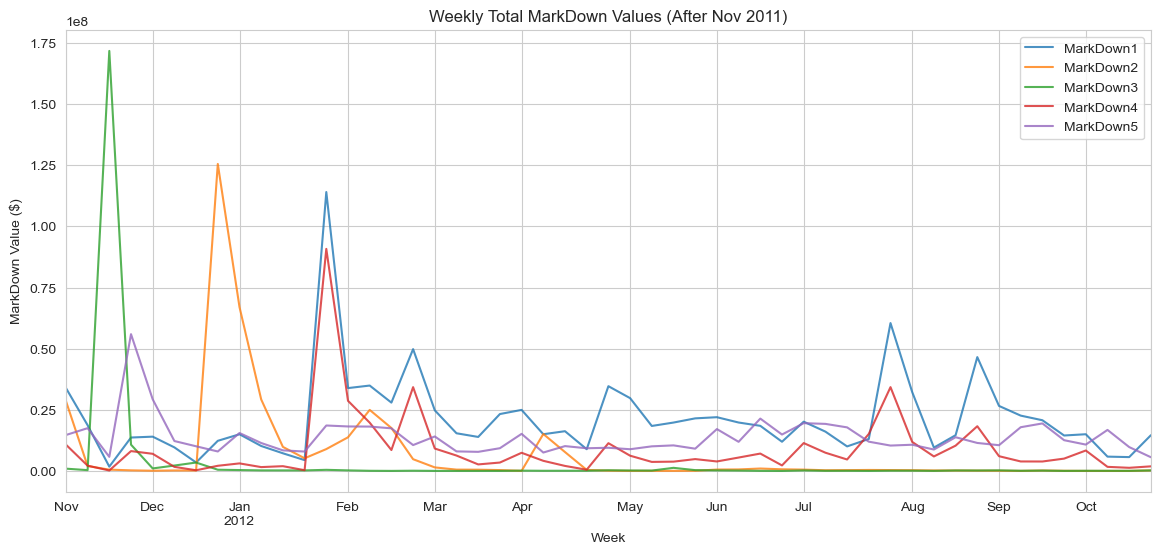

In [38]:
weekly_md = df_markdown.groupby('Week')[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].sum()


weekly_md.plot(figsize=(14,6), alpha=0.8)
plt.title('Weekly Total MarkDown Values (After Nov 2011)')
plt.ylabel('MarkDown Value ($)')
plt.xlabel('Week')
plt.show()

This line chart shows the weekly totals for markdown1 through markdown5, each representing a different type of promotional or discount program. markdown2 and markdown3 appear to be concentrated around Thanksgiving and New Year, suggesting they are used for event-driven promotions. In contrast, markdown1, markdown4, and markdown5 are active more consistently throughout the year, indicating they may be part of routine or ongoing discount strategies.
To better understand how these markdowns impact sales, we’ll take a closer look by calculating the correlation between total markdown values and weekly sales.

In [39]:
combined = pd.DataFrame({'Sales': weekly_sales, 'Total_MarkDown': weekly_markdown})
print(combined.corr())

                   Sales  Total_MarkDown
Sales           1.000000        0.143686
Total_MarkDown  0.143686        1.000000


0.14 is a very weak positive correlation. This suggests that while markdowns may contribute to higher sales in some cases, the overall effect is not strong or consistent enough to show a clear global trend. this weak correlation could be duo to several factors. Let's try stores.

In [40]:
# Check Correlation by Store
df_markdown.groupby('Store')[['Weekly_Sales', 'Total_MarkDown']].sum().corr()

,Weekly_Sales,Total_MarkDown
Weekly_Sales,1.000000,0.879905
Total_MarkDown,0.879905,1.000000


A strong positive correlation of 0.88 means that within each store, higher markdown spending is strongly associated with higher sales.
This shows a localized effect: markdowns don’t show strong global correlation because their impact varies by store — but within stores, the relationship is clear and powerful.

### 4.5 Encoding categorical data

In [41]:
df_train['IsHoliday'] = df_train['IsHoliday'].astype(int)
print(df_train['IsHoliday'].value_counts())

IsHoliday
0    391909
1     29661
Name: count, dtype: int64


In [42]:
df_test['IsHoliday'] = df_test['IsHoliday'].astype(int)
print(df_test['IsHoliday'].value_counts())

IsHoliday
0    106136
1      8928
Name: count, dtype: int64


In [43]:
#Ordinal Encoding
size_map = {'C': 0, 'B': 1, 'A': 2}
df_train['Type'] = df_train['Type'].map(size_map)

In [44]:
size_map = {'C': 0, 'B': 1, 'A': 2}
df_test['Type'] = df_test['Type'].map(size_map)

### 4.6 Relationship Between External Factors and Weekly Sales

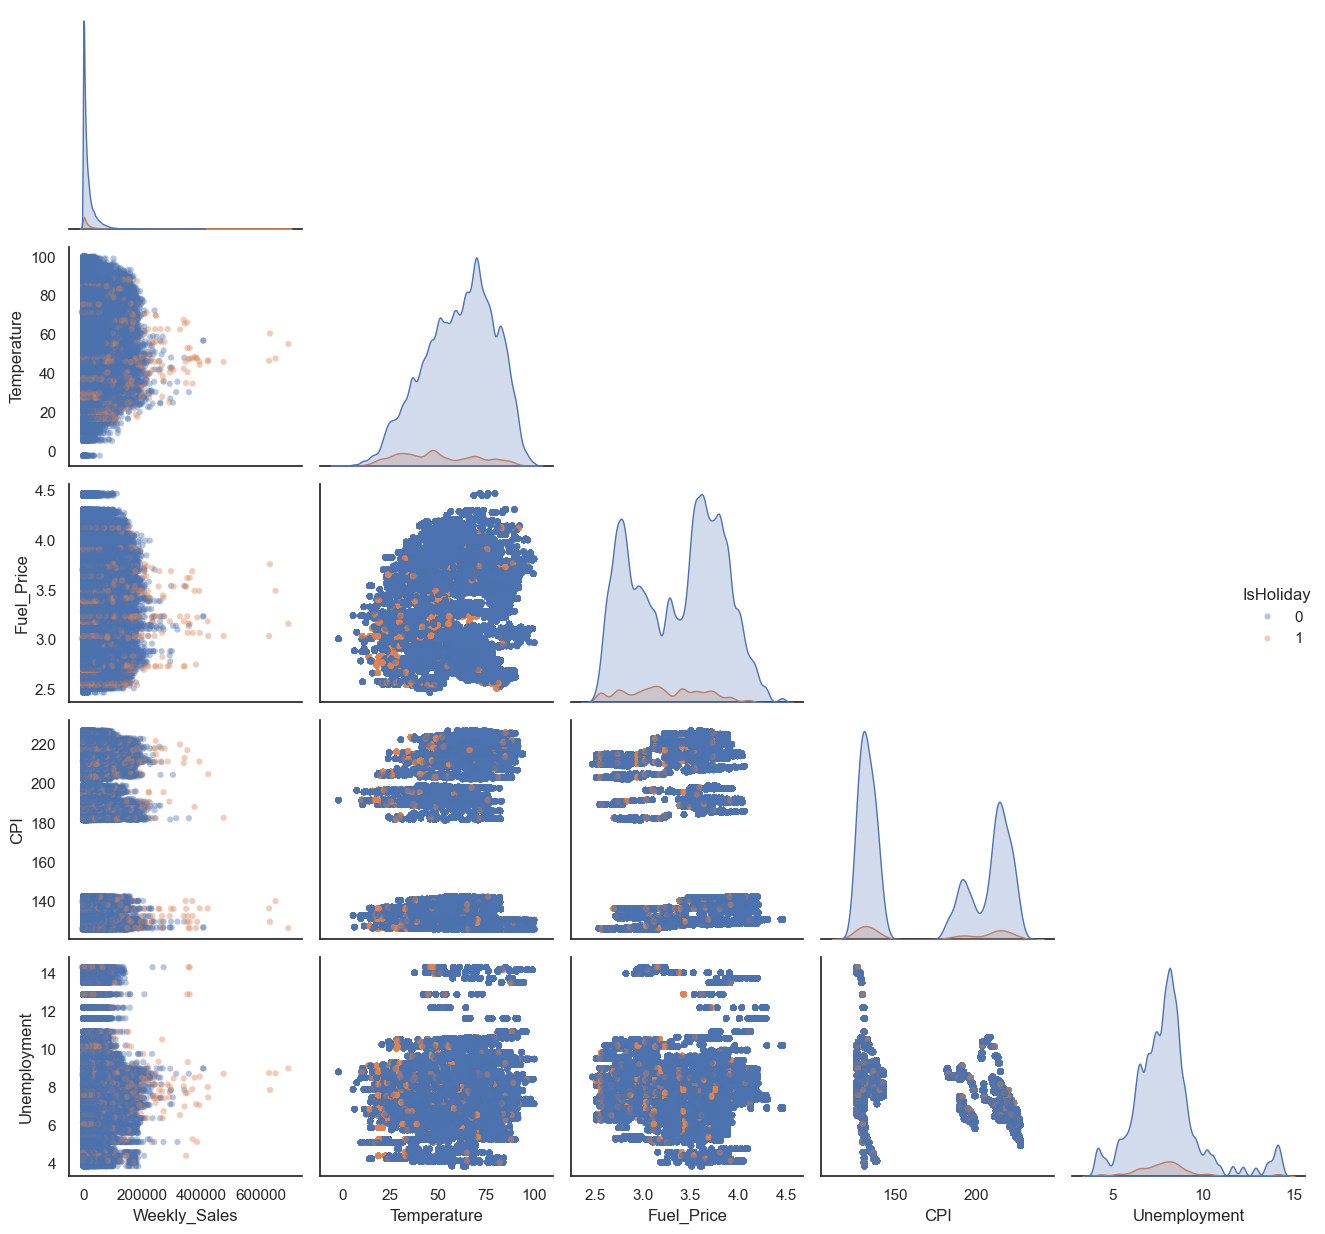

In [45]:
sns.set(style="white")

sns.pairplot(
    df_train[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']],
    hue='IsHoliday',
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha': 0.4, 's': 20, 'edgecolor': 'none'}  
)

plt.tight_layout()
plt.show()

We used a pair plot to explore the relationships between weekly sales and external factors like CPI,temperature,fuel price and unemployment. The plots show none of these features have a strong direct correlation with weekly sales. However, sales do tend to increase during colder weeks.

### 4.7 Feature correlation 
**Exploring relationships between all features**

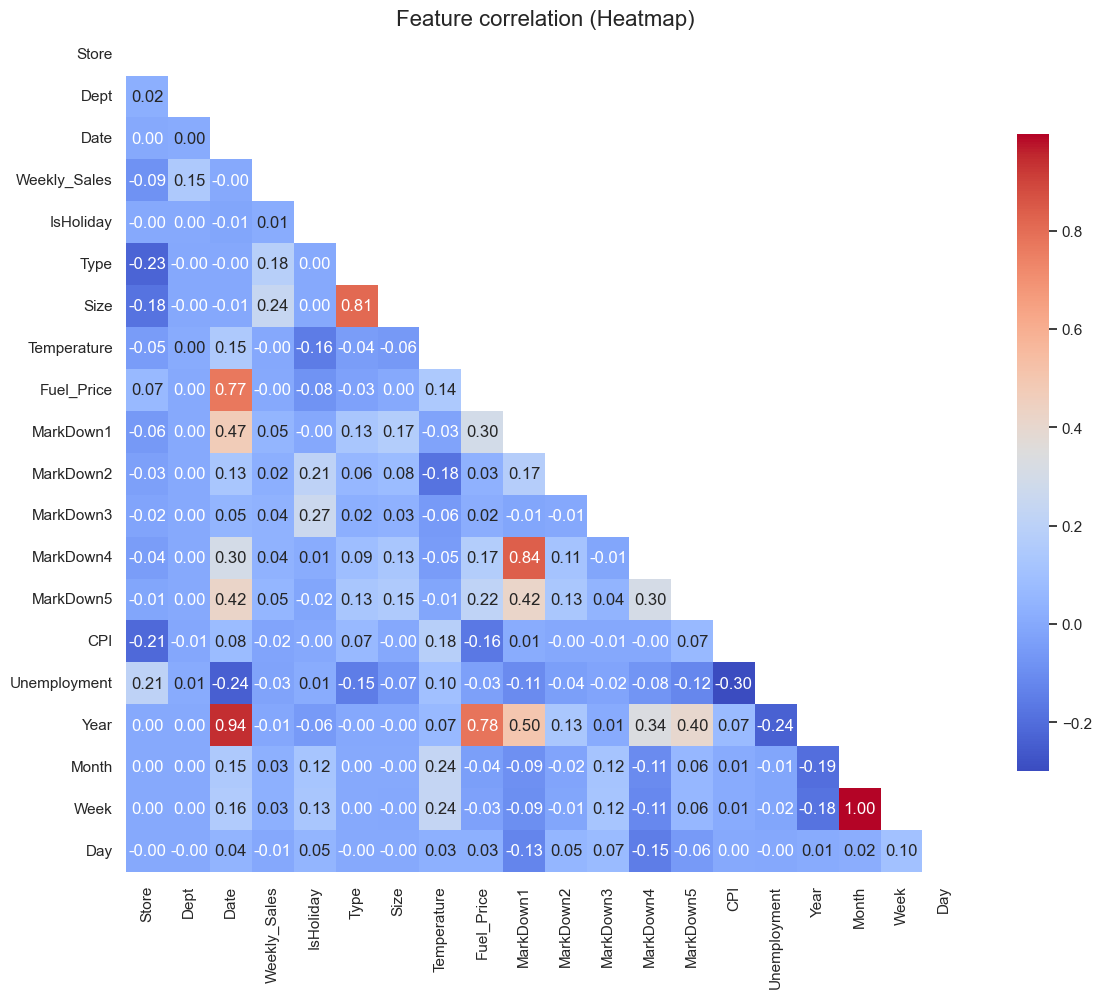

In [46]:
corr = df_train.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            mask=mask, 
            square=True, 
            cbar_kws={'shrink': 0.75},
            xticklabels=corr.columns,
            yticklabels=corr.columns)

plt.title('Feature correlation (Heatmap)', fontsize=16)
plt.tight_layout()
plt.show()

Type and Size have a strong correlation(0.81), and highly correlated features can cause issues in certain models like linear regression due to multicollinearity. Additionally, Month and Week are also highly correlated. Since our target is weekly sales, the Week variable already captures temporal patterns, and including both may introduce redundancy or noise. Therefore, the Month column can be excluded to simplify the model.


**Focus only on the correlation of each feature with Weekly_Sales**

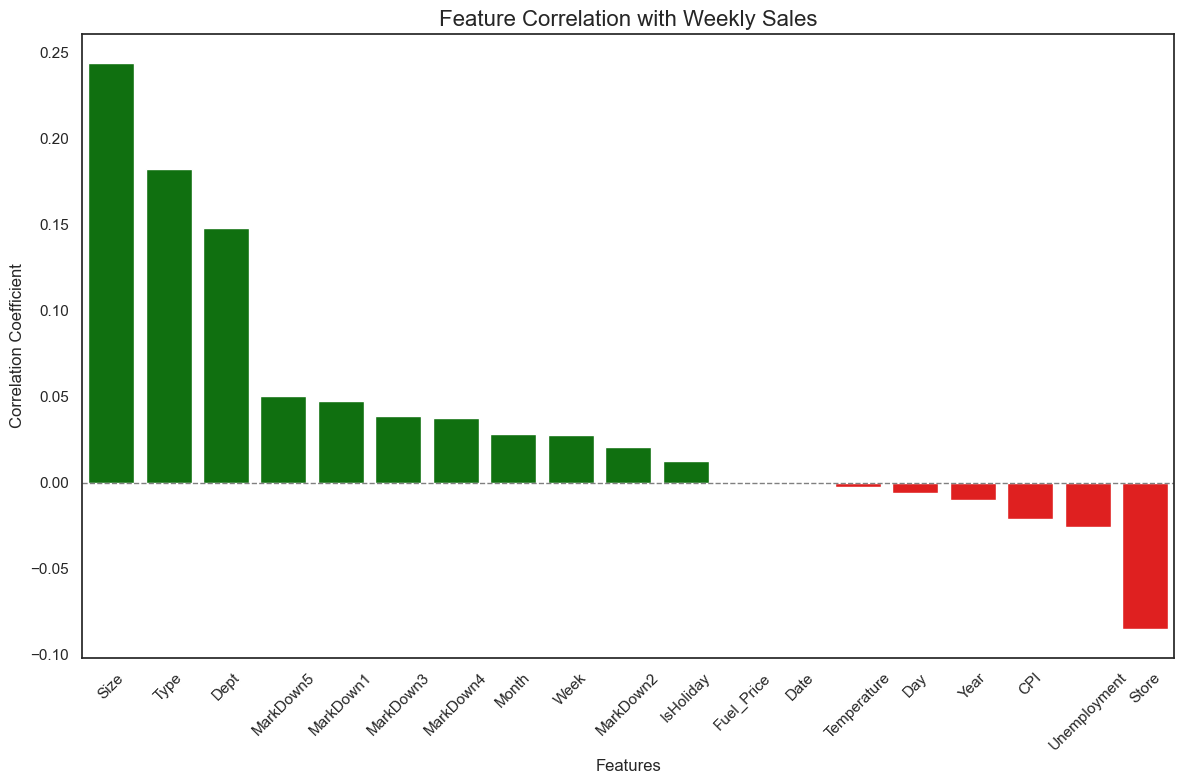

In [47]:
weekly_sales_corr = df_train.corr()['Weekly_Sales'].drop('Weekly_Sales').sort_values(ascending=False)

plt.figure(figsize=(12, 8))
colors = ['green' if val > 0 else 'red' for val in weekly_sales_corr.values]
sns.barplot(
    x=weekly_sales_corr.index, 
    y=weekly_sales_corr.values, 
    hue=weekly_sales_corr.index,
    legend=False,
    palette=colors)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.title('Feature Correlation with Weekly Sales', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The bar plot shows that Size, Type, and Dept are the most positively associated with weekly sales, while variables like CPI and Unemployment have minimal impact. 

## 5. Feature Engineering

In [48]:
data_train = df_train.copy()
data_test = df_test.copy()

In [49]:
# Holiday feature
# Define holiday dates
holiday_dates = {
    'SuperBowl': ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'],
    'LaborDay': ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
    'Thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'],
    'Christmas': ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
}
for k in holiday_dates:
    holiday_dates[k] = pd.to_datetime(holiday_dates[k])

holiday_weeks = {}

# Find which Week each holiday date corresponds to
for holiday, dates in holiday_dates.items():
    week_nums = df_train[df_train['Date'].isin(dates)]['Week'].unique()
    holiday_weeks[holiday] = list(week_nums)

for holiday, weeks in holiday_weeks.items():
    print(f"{holiday} falls in Week(s): {weeks}")

SuperBowl falls in Week(s): [6]
LaborDay falls in Week(s): [36]
Thanksgiving falls in Week(s): [47]
Christmas falls in Week(s): [52]


In [50]:
data_train['SuperBowl'] = (df_train['Week']==6).astype(int)
data_train['LaborDay'] = (df_train['Week']==36).astype(int)
data_train['ThanksgivingWeek'] = (df_train['Week'] == 47).astype(int)
data_train['ChristmasWeek'] = (df_train['Week'] == 52).astype(int)

In [51]:
data_test['SuperBowl'] = (df_test['Week']==6).astype(int)
data_test['LaborDay'] = (df_test['Week']==36).astype(int)
data_test['ThanksgivingWeek'] = (df_test['Week'] == 47).astype(int)
data_test['ChristmasWeek'] = (df_test['Week'] == 52).astype(int)

## 6. Feature Importance

In [52]:
# Drop target and Date from features
drop_columns = ['Date','Weekly_Sales']
features = data_train.drop(columns = drop_columns).columns.tolist() # Converts the Index to a Python list, storing it in features.

X = data_train[features].copy()
y = data_train.Weekly_Sales.copy()

data_sample = data_train.sample(frac=0.25, random_state=0)
X_sample = data_sample[features].copy()
y_sample = data_sample['Weekly_Sales'].copy()

X_train,X_valid,y_train,y_valid = model_selection.train_test_split(
    X_sample,y_sample,random_state=0,test_size=0.15
)
#Train XGBoost model
feat_model = xgb.XGBRegressor(random_state=0).fit(X_train, y_train)

#Run permutationImportance
perm = PermutationImportance(feat_model,random_state=1).fit(X_valid,y_valid)

eli5.show_weights(perm, top=len(X_train.columns), feature_names = X_valid.columns.tolist())

Weight,Feature
1.6054 ± 0.0345,Dept
0.4655 ± 0.0113,Size
0.1187 ± 0.0041,Store
0.0506 ± 0.0058,Week
0.0433 ± 0.0030,CPI
0.0166 ± 0.0033,ThanksgivingWeek
0.0086 ± 0.0008,Type
0.0071 ± 0.0009,Unemployment
0.0067 ± 0.0018,Temperature
0.0045 ± 0.0008,Day


Dept,Size,Store,Week,and CPI are the top 5 features.

## 7. Model Evaluation with WMAE
This project is evaluated on the weighted mean absolute error(WMAE)

In [53]:
models = {
    'LGBM':     lgb.LGBMRegressor(random_state=0),
    'XGBoost':  xgb.XGBRegressor(random_state=0, objective='reg:squarederror'),
    'Catboost': cb.CatBoostRegressor(random_state=0, verbose=False),
    'HGBR':     HistGradientBoostingRegressor(random_state=0),
    'ExtraTr':  ensemble.ExtraTreesRegressor(random_state=0, bootstrap=True),
    'RandomF':  ensemble.RandomForestRegressor(random_state=0),
}


In [54]:
def WMAE(dataset, real, predicted):
    weights = dataset['IsHoliday'].apply(lambda x: 5 if x else 1)
    return np.sum(weights * abs(real - predicted)) / np.sum(weights)

def model_evaluation(name, model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_valid)
    wmae = WMAE(X_valid, y_valid, y_preds)
    
    print(f"{name:<10} WMAE: {wmae:.2f}")
    return wmae

In [55]:
for name, model in models.items():
    model_evaluation(name, model, X_train, y_train, X_valid, y_valid)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 89583, number of used features: 22
[LightGBM] [Info] Start training from score 16002.803288
LGBM       WMAE: 4415.51
XGBoost    WMAE: 3383.22
Catboost   WMAE: 3702.79
HGBR       WMAE: 4391.73
ExtraTr    WMAE: 2481.87
RandomF    WMAE: 2025.92


Random Forest achieved the lowest WMAE (2025.92), outperforming other models.  We’ll use it as the baseline model for further tuning and comparison.

## 8. Baseline predictions 

In [56]:
# Prepare features and train/validation split
X_baseline = X[['Dept', 'Size', 'Store', 'Week', 'IsHoliday', 'Type', 'Year', 'Day']].copy()
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_baseline, y, test_size=0.1, random_state=0
)

In [57]:
# Train Random Forest
RF = ensemble.RandomForestRegressor(
    n_estimators=58, max_depth=25, min_samples_split=2, min_samples_leaf=1, random_state=0
)
RF.fit(X_train, y_train)


RandomForestRegressor(max_depth=25, n_estimators=58, random_state=0)

In [58]:
# Evaluate model
y_pred = RF.predict(X_valid)
assert len(y_pred) == len(y_valid)


def WMAE(X, y_true, y_pred):
    weights = X['IsHoliday'].apply(lambda x: 5 if x else 1)
    return (weights * abs(y_true - y_pred)).sum() / weights.sum()

wmae = WMAE(X_valid, y_valid, y_pred)
print(f"WMAE: {wmae:.2f}")

WMAE: 1359.78


In [59]:
# Predict on test set
test = data_test[['Dept', 'Size', 'Store', 'Week', 'IsHoliday', 'Type', 'Year', 'Day']].copy()
predict_rf = RF.predict(test)

## 9. Actual vs Forecast 

In [60]:

predicted_sales = data_test.copy()
predicted_sales['Weekly_Sales'] = predict_rf
predicted_sales.to_csv('predicted_weekly_sales.csv', index=False)

# Create 'Source' column for both datasets
df_actual = df_train[['Store', 'Dept', 'Year', 'Week', 'Weekly_Sales']].copy()
df_forecast = predicted_sales[['Store', 'Dept', 'Year', 'Week', 'Weekly_Sales']].copy()

df_actual['Source'] = 'Actual'
df_forecast['Source'] = 'Forecast'

# Combine actual and forecasted sales
df_combined = pd.concat([df_actual, df_forecast], ignore_index=True)

In [61]:
# Aggregate weekly total sales
df_weekly_total = (
    df_combined.groupby(['Year', 'Week', 'Source'])['Weekly_Sales']
    .sum()
    .reset_index()
    .sort_values(['Year', 'Week'])
)


df_weekly_total['Date'] = pd.to_datetime(
    df_weekly_total['Year'].astype(str) + df_weekly_total['Week'].astype(str) + '1',
    format='%G%V%u'
)


df_actual_plot = df_weekly_total[df_weekly_total['Source'] == 'Actual']
df_forecast_plot = df_weekly_total[df_weekly_total['Source'] == 'Forecast']


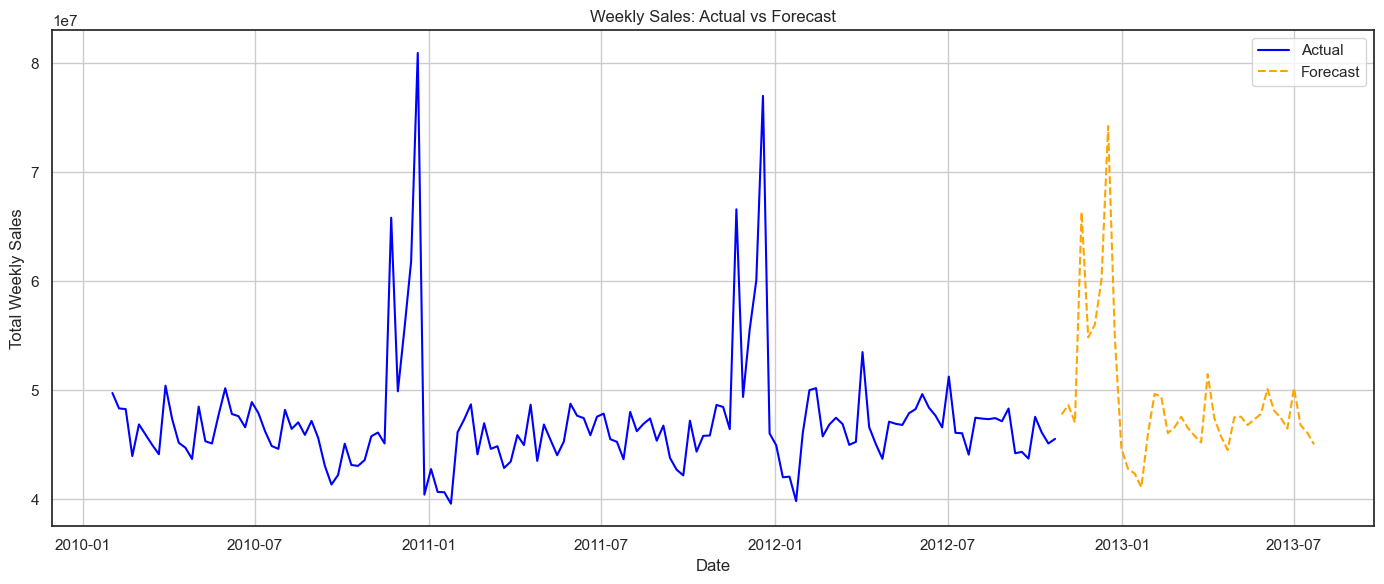

In [62]:
# Plot actual vs forecast
plt.figure(figsize=(14, 6))
plt.plot(df_actual_plot['Date'], df_actual_plot['Weekly_Sales'], label='Actual', color='blue')
plt.plot(df_forecast_plot['Date'], df_forecast_plot['Weekly_Sales'], label='Forecast', color='orange', linestyle='--')

plt.title("Weekly Sales: Actual vs Forecast")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()